# Non-IID Detection with Cleanlab

This quickstart notebook demonstrates the power of [cleanlab's](https://github.com/cleanlab/cleanlab) non-IID data detection on a handful of toy datasets, as well as on CIFAR10. The method used here is easily transferable to any other dataset and relies only on numerical representations of data (i.e. feature representations), rather than the data itself which makes it entirely agnostic to data modality! Simply run your favorite model on your favorite dataset to collect feature representations, then let [cleanlab](https://github.com/cleanlab/cleanlab) do the rest.

## Overview
In this tutorial, we will cover the following:

- What is non-IID data? Why might it be problematic?
- How does cleanlab detect non-IID data?
- How to use cleanlab to detect non-IID data
    - Detecting non-IID data with toy-datasets
    - Detecting non-IID data with CIFAR10

## What is non-IID data?

IID means "Indedependent and Identically Distributed." It describes a collection of datapoints which were sampled independently of each other from the exact same data generation process. One of the most important assumptions in many machine learning tasks is that the data is drawn IID. However, this is not always the case.

Data is non-IID if either the data is 1. Not independently sampled, or 2. not identically sampled. Examples of the second case are [concept drift](https://machinelearningmastery.com/gentle-introduction-concept-drift-machine-learning/), where the generating distribution of the data shifts over time. Detecting concept drift is important for training and testing models under real-world conditions. In general, the first case is impossible to detect, but we show some special cases below in which cleanlab detects this non-IID behavior. 

## How does cleanlab detect non-IID data?

cleanlab's non-IID detection algorithm is quite simple. Given a numerical representation of a dataset, cleanlab constructs a k-Nearest Neighbor graph of the dataset and groups all possible pairs of datapoints into neighbors and non-neighbors. Then, the algorithm computes the index-distance between pairs. That is, the distance between two points in the order of the dataset (e.g. the distance between the 8th datapoint and the 108th datapoint is 100). Then, cleanlab uses a two-sample test to determine if there is a statistically significant difference between the distributions of index-distances of the neighbors and that of the non-neighbors. If there is, then it means that neighbors and non-neighbors in feature space are distributed in different ways throughout this particular ordering of the dataset. This is a strong indication that the data is not IID.

## How to use cleanlab to detect non-IID data

First, install dependencies and import the necessary packages into python

In [1]:
!pip install matplotlib sklearn scipy numpy pandas datasets
!pip install cleanlab

In [2]:
import scipy
import random
import sklearn
import numpy as np
import pandas as pd

import cleanlab
from cleanlab import Datalab

from matplotlib import pyplot as plt
from datasets import Dataset, load_dataset

report = False
num_permutations = 15

/home/jesse/miniconda3/envs/cleanlab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Toy Datasets

First, we are going to try cleanlab out on toy datasets that we generate. We're going to generate data from a mixture of 10 Gaussian distributions with random means and variances which we assign in the following code block. These examples are contrived to demonstrate cleanlab's ability to attack this very challenging problem.

In [3]:
num_classes = 10
means = [np.array([np.random.uniform(high=10), np.random.uniform(high=10)]) for i in range(num_classes)]
sigmas = [np.random.uniform(high=1) for i in range(num_classes)]
class_stats = list(zip(means, sigmas))

In [4]:
k = 10
num_samples = 1000

#### IID

The first thing we're going to do is try cleanlab out on data that is drawn IID from the mixture of gaussians. Since the data is actually IID, cleanlab should not detect a significant difference.

In [5]:
def generate_data_iid():
    samples = []
    labels = []

    for i in range(num_samples):
        cls = np.random.choice(num_classes)
        mean, sigma = class_stats[cls]
        sample = np.random.normal(mean, sigma)
        samples.append(sample)
        labels.append(cls)
    samples = np.array(samples)
    labels = np.array(labels)

    plt.scatter(samples[:,0], samples[:,1])
    plt.axis('off')
    plt.show()
    
    dataset = Dataset.from_dict({'features': list(samples), 'labels': list(labels)})
    return dataset

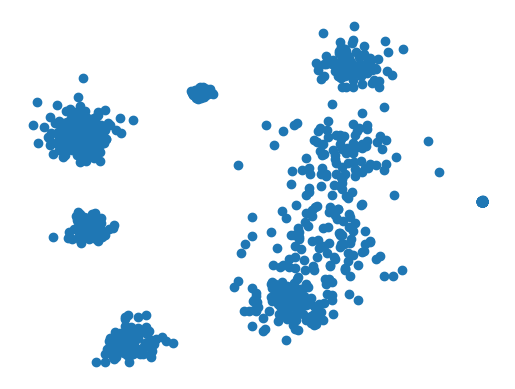

Finding non_iid issues ...
Search complete.
p-value = 0.7825450643560329


In [6]:
dataset = generate_data_iid()
datalab = Datalab(dataset, label_name='labels')
datalab.find_issues(features=dataset['features'], issue_types={'non_iid': {'metric': 'euclidean', 'num_permutations': num_permutations}})
print('p-value =', datalab.get_info('non_iid')['p-value'])
if report:
    datalab.report()

Above we show a visualization of the data and the p-value computed by cleanlab. As expected, the p-value is well above traditional significance thresholds of 0.05, 0.01, etc., which indicates that the data is IID.

#### Gradual mean shift

Our next example is data with a mean shift. Each time we draw a point from distribution, the means of each of the gaussians shift a little bit along the line $y=x$. This data is non-IID because each point is drawn from a slightly different distribution than the last.

In [7]:
def generate_data_gradual_mean_shift():
    samples = []
    labels = []

    for i in range(num_samples):
        cls = np.random.choice(num_classes)
        mean, sigma = class_stats[cls]
        shift = 2 * i / num_samples # gradually increasing a mean shift for each gaussian
        sample = np.random.normal(mean + shift, sigma)
        samples.append(sample)
        labels.append(cls)
    samples = np.array(samples)
    labels = np.array(labels)
    
    plt.scatter(samples[:,0], samples[:,1], c=np.arange(len(samples)))
    plt.colorbar(label='Datapoint index')

    plt.axis('off')
    plt.show()

    dataset = Dataset.from_dict({'features': list(samples), 'labels': list(labels)})
    return dataset

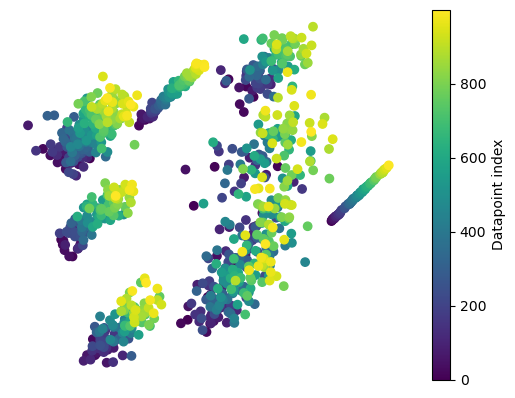

Finding non_iid issues ...
Search complete.
p-value = 0.0


In [8]:
dataset = generate_data_gradual_mean_shift()
datalab = Datalab(dataset, label_name='labels')
datalab.find_issues(features=dataset['features'], issue_types={'non_iid': {'metric': 'euclidean', 'num_permutations': num_permutations}})
print('p-value =', datalab.get_info('non_iid')['p-value'])
if report:
    datalab.report()

You can see the mean drift in the data visualization in which we have colored data using a gradient which reflects the point's index in the dataset There is a clear drift in the sampling of datpoints which occurs gradually over time. The clusters are no longer normally distributed around a central point and the later portion of the data is clearly shifted from the earlier portion. Cleanlab gives us a p-value of 0 here, correctly identifying the non-IID trend.

#### Variance changepoint

In this example, we explore another sort of distribution shift. This time, the means of the gaussians stay the same, but the variance of each doubles suddenly halfway through the sampling process.

In [9]:
def generate_data_variance_changepoint():
    samples = []
    labels = []

    for i in range(num_samples):
        cls = np.random.choice(num_classes)
        mean, sigma = class_stats[cls]
        shift = 0
        if i > num_samples / 2:
            shift = 1.5 * sigma # sudden increase in variance for each gaussian
        sample = np.random.normal(mean, sigma + shift)
        samples.append(sample)
        labels.append(cls)
    samples = np.array(samples)
    labels = np.array(labels)
    
    plt.scatter(samples[-500:, 0], samples[-500:, 1], color='tab:red', label='Last 500 points')
    plt.scatter(samples[:500, 0], samples[:500, 1], color='tab:blue', label='First 500 points')
    plt.axis('off')
    plt.legend()
    plt.show()
    # plt.scatter(samples[:,0], samples[:,1])
    # plt.show()

    dataset = Dataset.from_dict({'features': list(samples), 'labels': list(labels)})
    return dataset

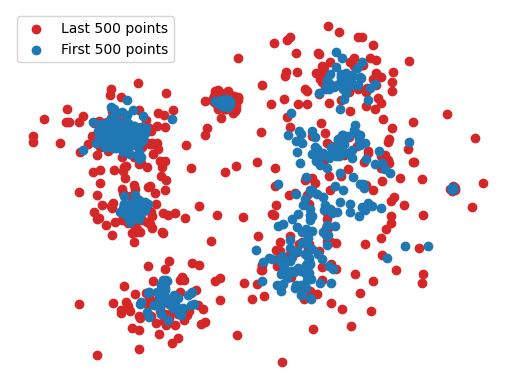

Finding non_iid issues ...
Search complete.
p-value = 0.0


In [10]:
dataset = generate_data_variance_changepoint()
datalab = Datalab(dataset, label_name='labels')
datalab.find_issues(features=dataset['features'], issue_types={'non_iid': {'metric': 'euclidean', 'num_permutations': num_permutations}})
print('p-value =', datalab.get_info('non_iid')['p-value'])
if report:
    datalab.report()

Again, in the visualization we have colored the first half and the second half of the data different colors so it's clear to see that the two halves are sampled from different distributions. Without the separate coloring, it is fairly hard to see that the variances changed, but cleanlab knows that the data is not IID.

#### Dependent but marginally identical

This case is a little more subtle. In this example, we sample three points from a standard two-dimensional normal distribution. Then, each of the following datapoints, $x_i$ is sampled from $\mathcal{N}(\alpha_1 x_{i - 1} + \alpha_2 x_{i-2} + \alpha_3 x_{i-3}, 1)$ where $a_1 + a_2 + a_3 = 0$. In this case, the sampling of each point is marginally identical, but the sampling is not indpendent. For this demonstration, we use $a_1 = 0.5, a_2 = 0.4, a_3 = -0.9$

In [11]:
def generate_data_dependent():
    samples = []
    labels = []

    a1 = 0.50
    a2 = 0.40
    a3 = 0 - (a1 + a2)
    for i in range(num_samples):
        if i < 3:
            sample = np.random.normal((0, 0), (1, 1))
        else:
            sample = np.random.normal(a1 * samples[i-1] + a2 * samples[i - 2] + a3 * samples[i-3], (1, 1))
        cls = 0
        samples.append(sample)
        labels.append(cls)
    
    samples = np.array(samples)
    labels = np.array(labels)

    plt.scatter(samples[:,0], samples[:,1])
    plt.axis('off')
    plt.show()

    dataset = Dataset.from_dict({'features': list(samples), 'labels': list(labels)})
    return dataset

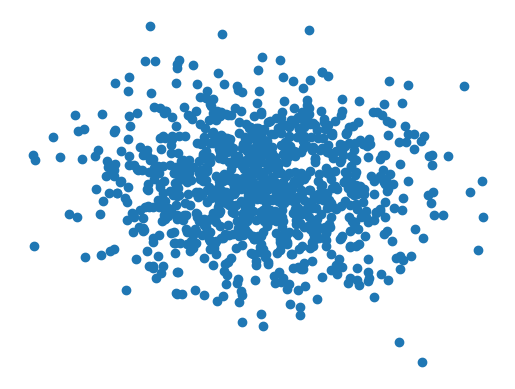

Finding non_iid issues ...
Search complete.
p-value = 1.3487729451829484e-13


In [12]:
dataset = generate_data_dependent()
datalab = Datalab(dataset, label_name='labels')
datalab.find_issues(features=dataset['features'], issue_types={'non_iid': {'metric': 'euclidean', 'num_permutations': num_permutations}})
print('p-value =', datalab.get_info('non_iid')['p-value'])
if report:
    datalab.report()

This time, it is really hard to tell from the visualization that anything funky is going on. If you look closely, you can see that the points tend to appear in small clusters of 2 or 3 which is the only giveaway since that wouldn't happen so often if the datapoints were sampled indepenently. However, cleanlab is correctly convinced that the data is not IID.

### CIFAR10

Now we'll show some more real-world examples of non-IID data using the CIFAR-10 image dataset. First, we load in precomputed feature representations of a subset of 10,000 CIFAR-10 images. Since this dataset is larger than our toy datasets, we'll set $k = 100$. Because of the size of our dataset and our choice of larger $k$, some of these examples will take around 30s to run.

In [13]:
k = 100

In [14]:
images = np.load('cifar10_images.npy')
feature_embeddings = np.load('cifar10_feature_embeddings.npy')
labels = np.load('cifar10_labels.npy')

num_classes = len(set(labels))
class_to_indices = {l: [] for l in set(labels)}
for i in range(len(labels)):
    label = labels[i]
    class_to_indices[label].append(i)

Below we've implemented a few helper functions for visualizing the data in the following examples.

In [15]:
def visualize_dataset(images, image_indices, group_labels):
        
    num_rows = len(image_indices)
    num_cols = len(image_indices[0])
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    for i, img_idx in enumerate(image_indices):
        # ax[i][0].set_ylabel(group_labels[i])
        for j in range(num_cols):
            ax[i][j].imshow(images[img_idx[j]])
            ax[i][j].set_xticklabels([])
            ax[i][j].set_xticks([])
            ax[i][j].set_yticklabels([])
            ax[i][j].set_yticks([])
    plt.show()
    
def visualize_class_distribution(labels, bins):
    num_bins = len(bins)
    classes = list(set(labels))
    class_bins = np.zeros((len(classes), num_bins))#np.array([[0 for i in range(num_bins)] for j in range(len(classes))])
    for i in range(num_bins):
        bin_start, bin_end = bins[i]
        binned_labels = labels[bin_start : bin_end]
        for cls in classes:
            count = np.sum(binned_labels == cls)

            class_bins[cls][i] = count / (bin_end - bin_start)

    width = bins[0][1] - bins[0][0]
    bins = [x[0] + ((x[1] - x[0]) / 2) for x in bins]
    bottom = np.zeros(num_bins)
    for cls_bin in class_bins:
        plt.bar(bins, cls_bin, width, bottom=bottom)
        bottom += cls_bin
        
    plt.title('Class distribution across the dataset')
    plt.xlabel('Datapoint index')
    plt.ylabel('Proportion of dataset')
    plt.show()

#### Datapoint Scores

We will also present the per example scores that cleanlab computes for each image in the dataset. Unlike other data issues that cleanlab identifies like [label issues](https://docs.cleanlab.ai/stable/index.html), [outlier detection](https://docs.cleanlab.ai/stable/tutorials/outliers.html), etc., in which each datapoint is assigned a score and the user can decide which to label as issues based on a user-provided threshold, the main result of this non-IID issue check is an aggregate score across the entire dataset. The p-value that cleanlab reports applies to the entire dataset and is not easily interpretable on the more granular, datapoint-scale.

In addition to the non-IID p-value, cleanlab also computes and reports datapoint scores. This is done by computing the same aggregated test statistic for the neighbors and non-neighbors of an individual datapoint. The statistics are then transformed to within $[0,1]$ such that scores close to 0 indicate datapoints for which the distributions of its neighbors and non-neighbors are more different.

These scores are intendended to help the user determine what exactly the non-IID issue in the dataset might be. For this reason, the distribution of the scores over the order of the dataset is much more instructive than the values of the scores themselves. Indeed, in some cases, low datapoint scores may be inversely correlated with problematic examples or may not have any correlation whatsoever. The scores may not have a clear interpretation for datasets that are IID or datasets in which the departure from IID is subtle. In the following examples, we visualize the distributions of the datapoint scores and provide commentary about what they tell us about the dataset.

Cleanlab also reports a judgment for each example in the dataset as to whether it may be an non-IID issue or not. These individual issue judgments are determined simply by thresholding on the datapoint scores and are intended to give the user a very coarse summary of particularly bad examples and will not tell the whole story. We recommend that, when possible, the user analyzes all of the datapoint scores collectively rather than rely on the individual issue judgments. This is what we demonstrate in the rest of the notebook.

We will visualize the scores using the following function

In [16]:
def visualize_datapoint_scores(datalab, ylim=(0,1)):
    issues = datalab.issues
    scores = issues['non_iid_score'].tolist()

    plt.scatter(np.arange(len(scores)), scores)
    plt.ylim(ylim)
    plt.title('Datapoint score vs. Datapoint index')
    plt.xlabel('Datapoint index')
    plt.ylabel('Datapoint score')
    plt.show()

#### Random shuffle

First, we establish a baseline by testing cleanlab's algorithm on randomly shuffled data. In this case, the data is IID so cleanlab should produce a non-significant p-value.

In [17]:
def generate_data_random_shuffle():
    perm = np.random.permutation(len(feature_embeddings))
    permuted_embeddings = feature_embeddings[perm]
    permuted_images = images[perm]
    
    num_rows = 4
    num_cols = 4
    group_indices = sorted(np.random.choice(np.arange(0, len(permuted_images), num_cols), size=num_rows))
    image_indices = [[group_idx + i for i in range(num_cols)] for group_idx in group_indices]
    group_labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
    visualize_dataset(permuted_images, image_indices, group_labels)

    dataset = Dataset.from_dict({'features': list(permuted_embeddings), 'labels': list(labels)})
    return dataset

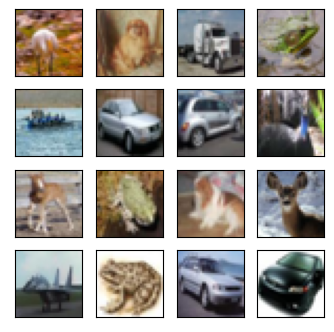

Finding non_iid issues ...
Search complete.
p-value = 0.6977652912662545


In [18]:
dataset = generate_data_random_shuffle()
datalab = Datalab(dataset, label_name='labels')
datalab.find_issues(features=dataset['features'], issue_types={'non_iid': {'k': 200, 'num_permutations': num_permutations}})
print('p-value =', datalab.get_info('non_iid')['p-value'])

The image grid above visualizes a subset of the images in the dataset in which the images are in random order . As expected, the p-value is not significant.

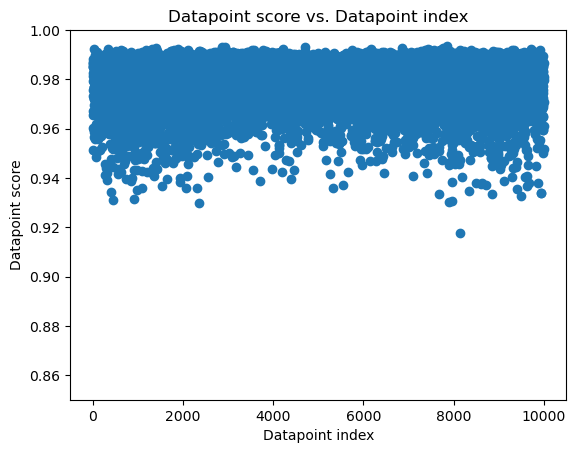

In [19]:
visualize_datapoint_scores(datalab, ylim=(0.85, 1))
if report: # to see individual issue judgments, set report to True
    datalab.report()

The datapoint scores are visualized above. The scores look largely uniformly distributed across the whole dataset. In the following examples, we will see distributions that depart greatly from this.

#### Sorted by class

The next case is somewhat extreme. We sort the data such that all images of the same class appear in contiguous subsets. This data is very clearly not IID and cleanlab should be able to detect this decisively.

In [20]:
def generate_data_sorted_order():
    sorted_order = np.argsort(labels)
    sorted_embeddings = feature_embeddings[sorted_order]
    sorted_images = images[sorted_order]

    num_rows = 4
    num_cols = 4
    group_indices = [0, 2000, 4000, 6000]
    image_indices = [[group_idx + i for i in range(num_cols)] for group_idx in group_indices]
    group_labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
    visualize_dataset(sorted_images, image_indices, group_labels)
    
    dataset = Dataset.from_dict({'features': list(sorted_embeddings), 'labels': list(labels[sorted_order])})
    return dataset

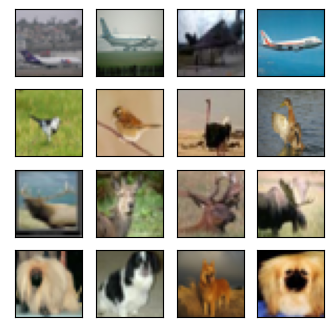

Finding non_iid issues ...
Search complete.
p-value = 0.0


In [21]:
dataset = generate_data_sorted_order()
datalab = Datalab(dataset, label_name='labels')
datalab.find_issues(features=dataset['features'], issue_types={'non_iid': {'k': 200, 'num_permutations': num_permutations}})
print('p-value =', datalab.get_info('non_iid')['p-value'])

In the visualization above, each row contains images of the same object class and each row representing a different object class which is how the dataset is now sorted. This is extremely non-IID and cleanlab detects it easily.

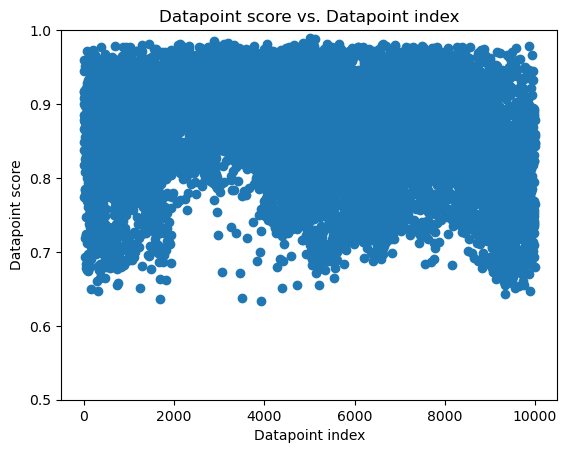

In [22]:
visualize_datapoint_scores(datalab, ylim=(0.5, 1))
if report:
    datalab.report()

In these datapoint scores there is very clear structure that differs significantly from that of the shuffled dataset. The variance of the scores is also very much larger than in the IID example (notice the scale of the y-axis). In this example, however, the scores that are lower than others don't actually say much about what is wrong with the dataset. The structure of the distribution is a much stronger signal.  The scores seem roughly grouped with sudden, regular shifts. This is an indication to the user to look at datapoints around each of these shifts to investigate what might be happening. In this case, the sudden shifts align with the transitions between class subsets that appear in the dataset one after another.

#### Concept Drift

In this example, we sample the datapoints independently from the 10 object classes according to a class distribution that changes over time. At first, the classes are all equally probable to be sampled from, but over time the distribution shifts such that some classes become more prevalant, and some less.

In [23]:
def generate_data_concept_drift():
    initial_weight = np.array([0.1 for i in range(len(class_to_indices))])
    drifted_weight = np.array([0.2, 0.2, 0.05, 0.025, 0.05, 0.15, 0.125, 0.025, 0.15, 0.025])
    num_samples = 5_000
    classes = [l for l in class_to_indices.keys()]
    drifted_class_to_indices = {k: v[:] for k,v in class_to_indices.items()}
    for v in drifted_class_to_indices.values():
        random.shuffle(v)
    drifted_sort = []
    for i in range(num_samples):
        if i < num_samples / 3:
            cls = np.random.choice(classes, p=initial_weight, size=1)[0]
        elif i >= num_samples / 3 and i < num_samples * 2 / 3: # gradually introduce the drift
            interval = num_samples / 3
            weights = initial_weight * ((2 * interval - i)/ interval) + drifted_weight * ((i - interval) / interval)
            cls = np.random.choice(classes, p=weights, size=1)[0]
        else:
            cls = np.random.choice(classes, p=drifted_weight, size=1)[0]
        idx = drifted_class_to_indices[cls].pop()
        drifted_sort.append(idx)
    
    drifted_embeddings = np.array(feature_embeddings)[drifted_sort]
    drifted_labels = labels[drifted_sort]
    drifted_images = images[drifted_sort]
    
    dataset = Dataset.from_dict({'features': list(drifted_embeddings), 'labels': list(labels[drifted_sort])})
    return dataset, drifted_labels

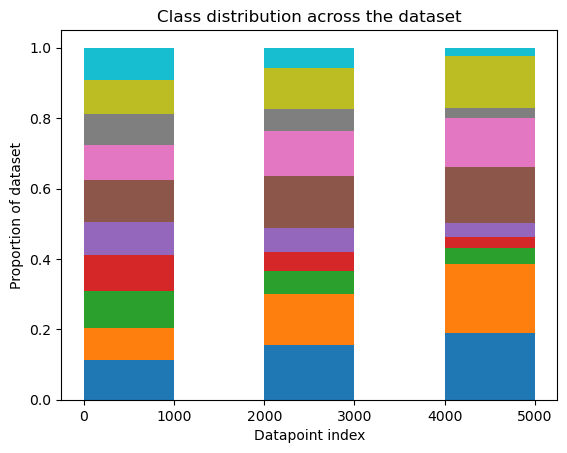

Finding non_iid issues ...
Search complete.
p-value = 3.422902331943571e-09


In [24]:
dataset, drifted_labels = generate_data_concept_drift()
datalab = Datalab(dataset, label_name='labels')
visualize_class_distribution(drifted_labels, bins=[(0, 1000), (2000, 3000), (4000, 5000)])
datalab.find_issues(features=dataset['features'], issue_types={'non_iid': {'k': 200, 'num_permutations': num_permutations}})
print('p-value =', datalab.get_info('non_iid')['p-value'])

In the visualization above, we plot the class distributions of 3 sections of the data in the first, second and last thirds of the data. It's clear from the makeup of the bars that the distributions of the classes shifts significantly in the middle of the dataset. Cleanlab correctly identifies that there is a problem with the dataset. This is an important example since concept drift during data collection can seriously effect model training and deployment performance if not identified properly.

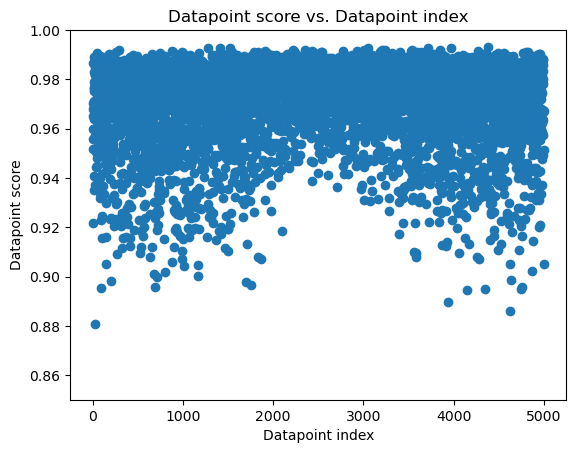

In [25]:
visualize_datapoint_scores(datalab, ylim=(0.85, 1))
if report:
    datalab.report()

The datapoint scores for this dataset show significantly higher variance in the scores on either end of the dataset with the highest scores with least variance for datapoints near the middle of the dataset although the scores themselves fall within a similar range as in the shuffled example. This is an indication that the distributions of neighbors is much different near the middle of the dataset than it is at either the beginning or the end. In this case, this is consistent with the gradual concept drift that takes place in the middle third of the dataset.

Comparing this scatterplot with the class distribution bar chart plotted in the previous cell demonstrates a strong coincidence of the scores with the presence of the distribution shift. The datapoints that are near the beginning and end of the datasets are drawn from very different distributions than is found on the other side of the shift. This results in neighbor and non-neighbor distributions that are significantly different. On the other hand, the class distribution in the middle of the dataset is more similar to the distributions on either side which results in neighbor and non-neighbor distributions that are more similar to each other.

#### Contiguous class subset

In this example, all the data is IID, except that we insert a small contiguous subset of images that are drawn all from the same class halfway through the dataset. 

In [26]:
def generate_data_contiguous_subset():
    insert_class_to_indices = {k: v[:] for k,v in class_to_indices.items()}
    for v in class_to_indices.values():
        random.shuffle(v)
        
    classes = [l for l in class_to_indices.keys()]

    insert_sort = []
    num_samples = 2_500
    for i in range(num_samples):
        cls = np.random.choice(np.arange(len(classes)), size=1)[0]
        idx = insert_class_to_indices[cls].pop()
        insert_sort.append(idx)

    split_point = 1250
    insert_size = 200
    insert_sort = insert_sort[:split_point] + insert_class_to_indices[0][:insert_size] + insert_sort[split_point:]
    insert_embeddings = np.array(feature_embeddings)[insert_sort]
    insert_images = images[insert_sort]
    insert_labels = labels[insert_sort]
    
    num_rows = 3
    num_cols = 4
    group_indices = [0, 1300, 2000]
    group_labels = ['Before subset', 'In subset', 'After subset']
    image_indices = [[group_idx + i for i in range(num_cols)] for group_idx in group_indices]
    visualize_dataset(insert_images, image_indices, group_labels)
    
    dataset = Dataset.from_dict({'features': list(insert_embeddings), 'labels': list(labels[insert_sort])})
    return dataset, insert_labels

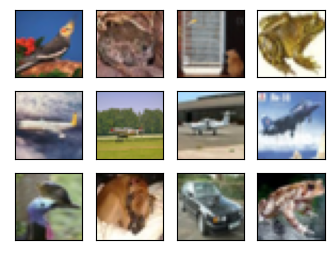

Finding non_iid issues ...
Search complete.
p-value = 1.9826436788624357e-12


In [27]:
dataset, insert_labels = generate_data_contiguous_subset()
datalab = Datalab(dataset, label_name='labels')
datalab.find_issues(features=dataset['features'], issue_types={'non_iid': {'k': 200, 'num_permutations': num_permutations}})
print('p-value =', datalab.get_info('non_iid')['p-value'])
if report:
    datalab.report()

The image grid gives a simple visualization of dataset in which the first and last rows have images with random object classes, but the middle row contains all images of the same class. 

Cleanlab detects that the data is not IID. This is useful because in many large data collection processes, the data may not be independent. For example, a common problem when scraping the web to collect image datasets is collecting frames of a video. Cleanlab would be able to detect if a section of your dataset contains a video in it.

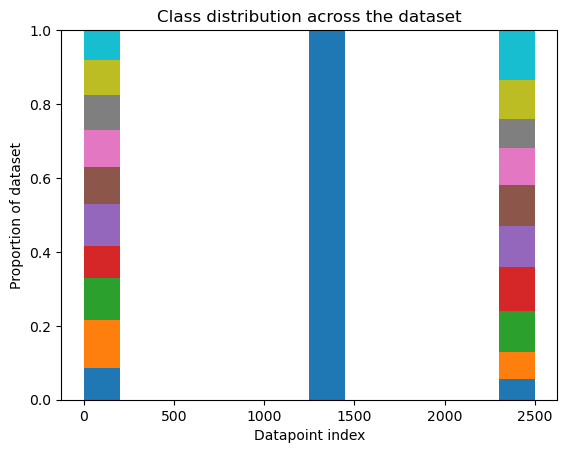

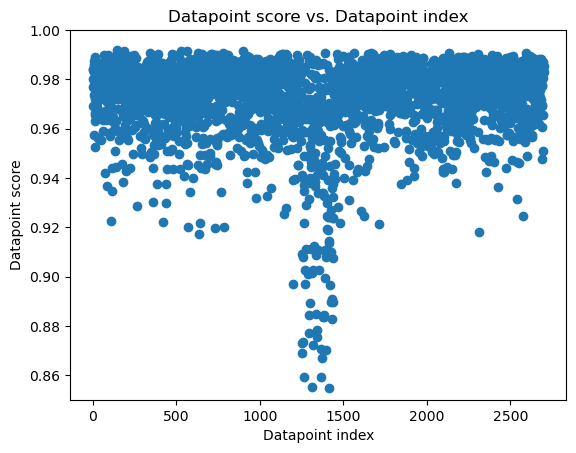

In [28]:
visualize_class_distribution(insert_labels, bins=[(0, 200), (1250, 1450), (2300, 2500)])
visualize_datapoint_scores(datalab, ylim=(0.85, 1))
if report:
    datalab.report()

The datapoint scores of this dataset are the most striking and clearest to interpret. The sharp downward spike in the scores is coincident with the small contiguous class subset that is inserted in the middle of the dataset which is also shown in the class distribution barplot. The images in this subset have many very close neighbors which results in larger differences between their neighbor and non-neighbor distributions. The datapoint scores reflect this convincingly.

## Conclusion

As shown here, non-IID data comes in many shapes and sizes. Although its impossible to detect _all_ kinds of non-IID data, cleanlab can detect many common kinds of problems in non-IID data. How important determining whether your data is IID or not is important depends on your use-case. If you are training a model on a standard dataset like CIFAR-10, you can solve non-IID problems simply by shuffling your dataset. However, if you are curating datasets via some data collection or generation process, identifying non-IID data can make you aware of underlying issues in your data collection or generating distribution. 